In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from cycler import cycle

In [2]:
# constants
DATA_PATH = '../data/'
EDUCATION_PATH = DATA_PATH + 'education/'

In [3]:
try:
    df_edu_all = pd.read_pickle(EDUCATION_PATH + 'DOE-college-data.pickle')
except FileNotFoundError:
    df_edu_all = pd.read_csv(EDUCATION_PATH + 'Most-Recent-Cohorts-All-Data-Elements.csv',encoding = 'ISO-8859-1')
    df_edu_all.to_pickle(EDUCATION_PATH +'DOE-college-data.pickle')

In [4]:
# creating list of column names found in ../data/education/CollegeScorecardDataDictionary.xlsx
# percentage of degrees awarded per major
columns = ['PCIP0' + str(i) if len(str(i)) == 1 else 'PCIP' + str(i) for i in range(1,55)]
# mean earnings of students after 10 years
columns.append('MN_EARN_WNE_P10')
# median earnings of students after 10 years
columns.append('MD_EARN_WNE_P10')
# admission rate of university 
columns.append('ADM_RATE')
# university name
columns.insert(0,'INSTNM')

In [5]:
# filter useful columns
df_edu = df_edu_all.filter(columns, axis=1)

In [6]:
# bring in actual degree names
major_names = [
    'Agricultureand Related Sciences',
    'Natural Resources and Conservation',
    'Architecture',
    'Ethnic, Cultural, Gender Studies',
    'Communication, Journalism',
    'Communications and Support Services',
    'Computer and Information Science',
    'Personal and Culinary Services',
    'Education',
    'Engineering',
    'Engineering Technologies',
    'Literatures, and Linguistics',
    'Family and Consumer Sciences',
    'Legal Professions and Studies',
    'English Language',
    'Liberal Arts,General Studies and Humanities',
    'Library Science',
    'Biological and Biomedical Sciences',
    'Mathematics and Statistics',
    'Military Technologies and Applied Sciences',
    'Multi/Interdisciplinary Studies',
    'Parks, Recreation, Leisure, and Fitness Studies',
    'Philosophy and Religious Studies',
    'Theology and Religious Vocations',
    'Physical Sciences',
    'Science Technologies/Technicians',
    'Psychology',
    'Protective Services',
    'Social Service Professions',
    'Social Sciences',
    'Construction Trades',
    'Mechanic and Repair Technologies/Technicians',
    'Precision Production',
    'Transportation and Materials Moving',
    'Visual and Performing Arts',
    'Health Professions',
    'Business, Management, Marketing',
    'History'
]

In [7]:
# find most common degrees award to students from all universities
major_list = []
major_list_col_form = []
# filter out degree columns
df_edu_cols = list(df_edu.columns[1:39])
# iterate through df
for i in range(1,len(df_edu)+1):
    # pull out degree column values for a given row
    major_vals = df_edu.iloc[i-1:i, 1:39].values
    # ensure sum is close enough to 1
    if(np.sum(major_vals) > .95):
        # find index of max element
        max_idx = np.argmax(major_vals)
        # append actual degree name
        major_list.append(major_names[max_idx])
        # append column name
        major_list_col_form.append(df_edu_cols[max_idx])

In [8]:
# function to generate a dictionary from a tuple list
def generate_dict_from_tup_list(tup_list):
    return {tup[0] : tup[1] for tup in tup_list}

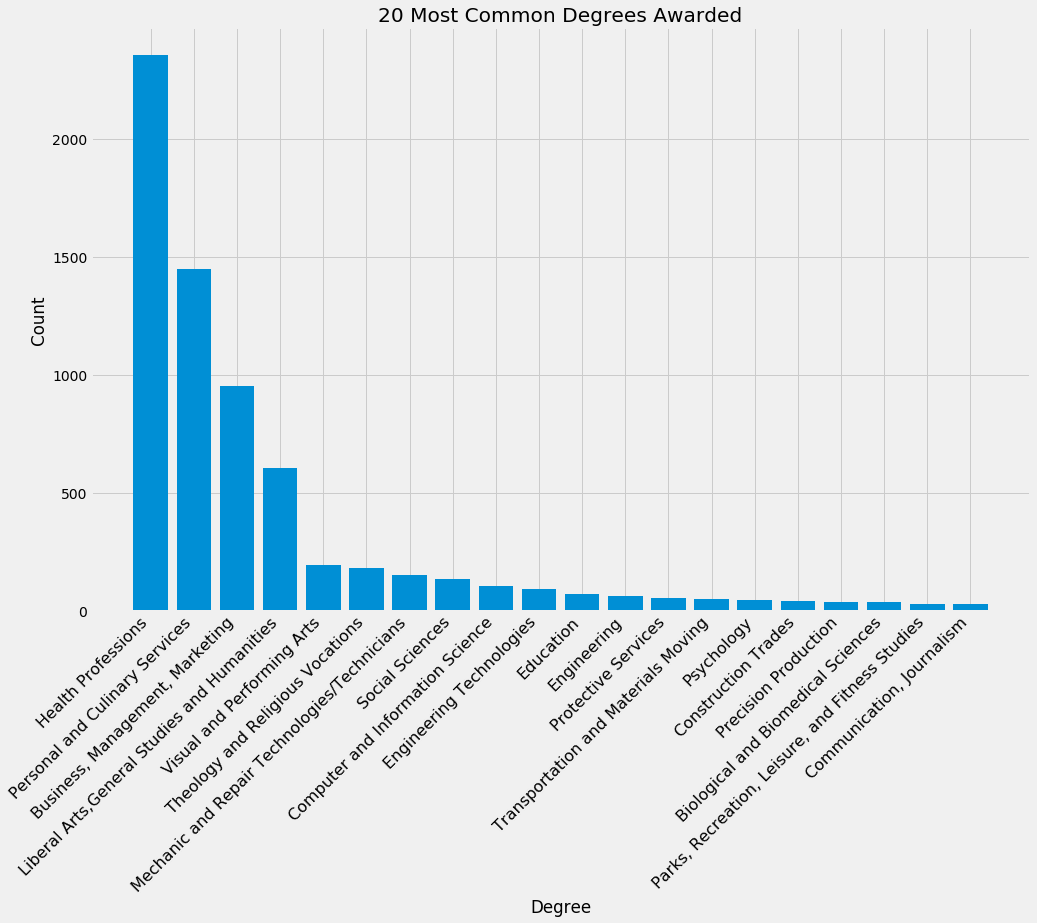

In [9]:
# select number of degrees to consider
top_majors_num = 20
# generate dictionary
major_count_dict = generate_dict_from_tup_list(Counter(major_list).most_common(top_majors_num))
# begin plotting
f, ax = plt.subplots(figsize=(15,10))
ax.bar(range(top_majors_num), major_count_dict.values(), align='center')
ax.set_xticks(range(top_majors_num))
ax.set_xticklabels(major_count_dict.keys(), rotation=45, fontsize=16, ha='right')
ax.set_title(str(top_majors_num) + ' Most Common Degrees Awarded')
ax.set_xlabel('Degree')
ax.set_ylabel('Count')
plt.show()

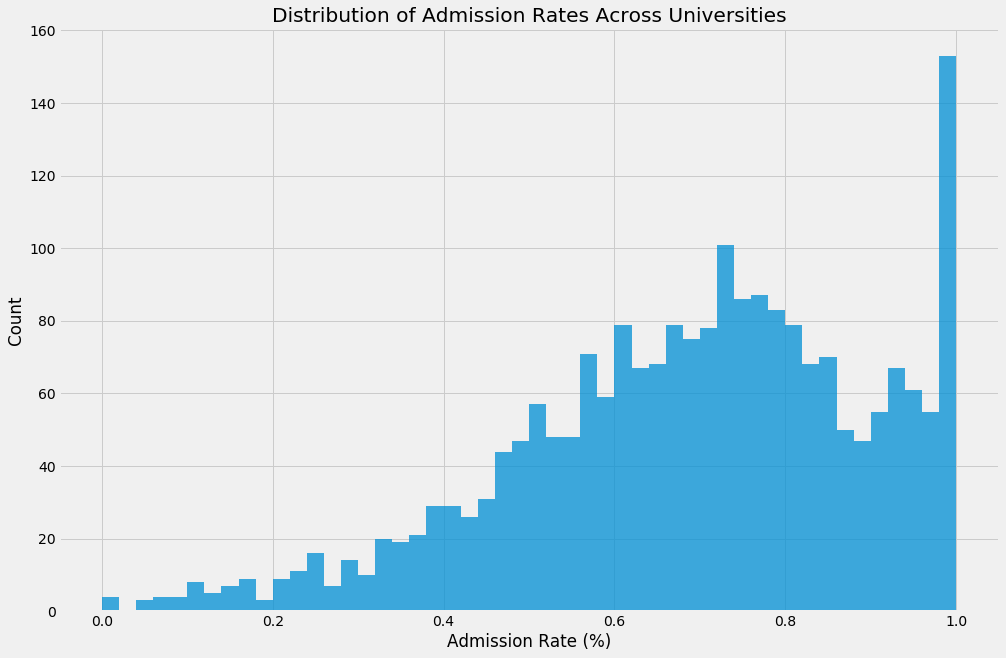

In [10]:
# focus on admission rates, remove nan and sort 
x = df_edu['ADM_RATE'].dropna().sort_values().tolist()
# begin plotting
f, ax = plt.subplots(figsize=(15,10))
ax.hist(x, bins=50, alpha=.75)
ax.set_title('Distribution of Admission Rates Across Universities')
ax.set_ylabel('Count')
ax.set_xlabel('Admission Rate (%)')
plt.show()

In [11]:
# create new list of columns for new df
# use columns from before
columns = df_edu.columns.tolist()
# add unemployement rate
columns.append('UNEMP_RATE')
# add percentile earnings after 6 years
columns.append('PCT10_EARN_WNE_P6')
columns.append('PCT25_EARN_WNE_P6')
columns.append('PCT75_EARN_WNE_P6')
columns.append('PCT90_EARN_WNE_P6')

In [12]:
# create new df
df_edu_unemp = df_edu_all[columns]

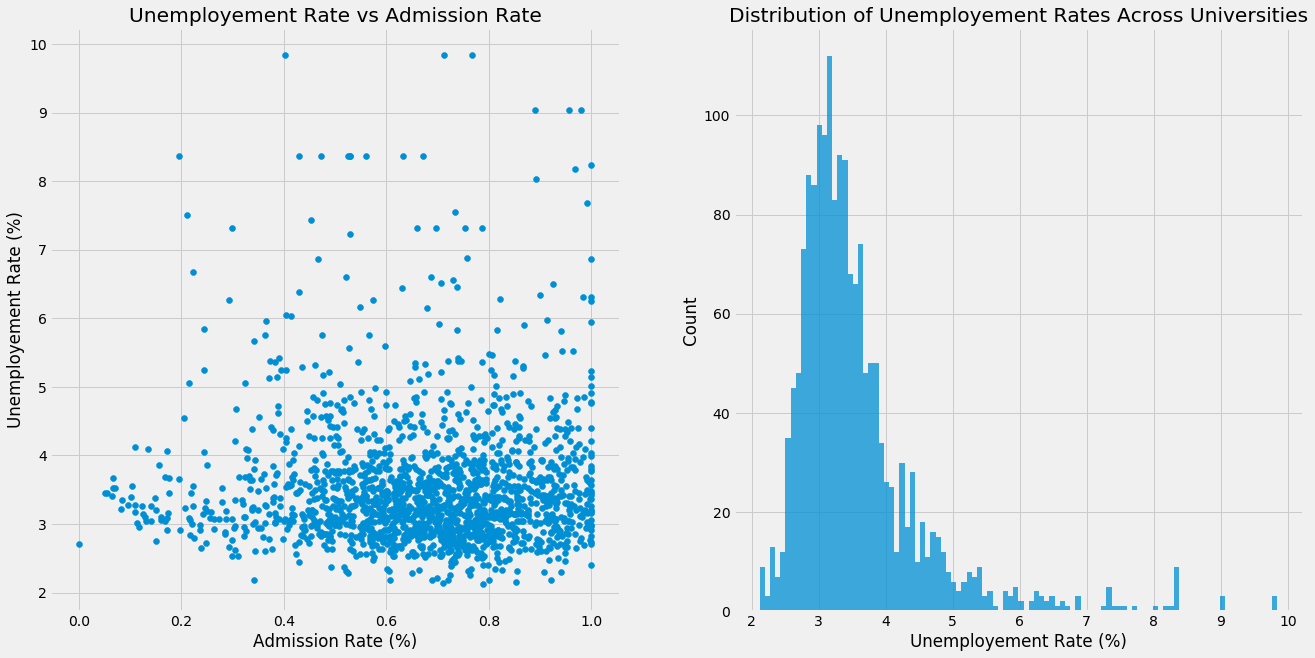

In [13]:
# begin plotting
f, (ax,ax1) = plt.subplots(1,2, figsize=(20,10))
# unemployement rate vs admission rate
df_edu_unemp = df_edu_unemp.replace('PrivacySuppressed', np.nan)
df_edu_unemp = df_edu_unemp.dropna()
ax.scatter(df_edu_unemp['ADM_RATE'], df_edu_unemp['UNEMP_RATE'])
ax.set_title('Unemployement Rate vs Admission Rate')
ax.set_xlabel('Admission Rate (%)')
ax.set_ylabel('Unemployement Rate (%)')
    
# unemployement distribution
x = df_edu_unemp['UNEMP_RATE'].tolist()
x = [float(i) for i in x]
ax1.hist(x, bins=100, alpha=.75)
ax1.set_title('Distribution of Unemployement Rates Across Universities')
ax1.set_ylabel('Count')
ax1.set_xlabel('Unemployement Rate (%)')
plt.show()

In [14]:
len(df_edu_unemp['ADM_RATE'])

1720

In [15]:
# create dictionary with most popular degrees mapped to lists
major_unemp_dict = {key:[] for key in major_count_dict.keys()}

In [16]:
# iterate over df
for i in range(1, len(df_edu_unemp)+1):
    # find max index of degree values
    max_idx = np.argmax(df_edu_unemp.iloc[i-1:i, 1:39].values[0])
    # get actual degree value
    major_val = major_names[max_idx]
    # if degree is pupular, add unemployement rate to it's corresponding list
    if(major_val in major_unemp_dict):
        major_unemp_dict[major_val].append(df_edu_unemp.iloc[i-1:i, 42].values[0])

In [17]:
# ensures all list elements of a larger list are floats
def make_floats(X):
    for l in X:
        for i in range(len(l)):
            l[i] = float(l[i])
    return X


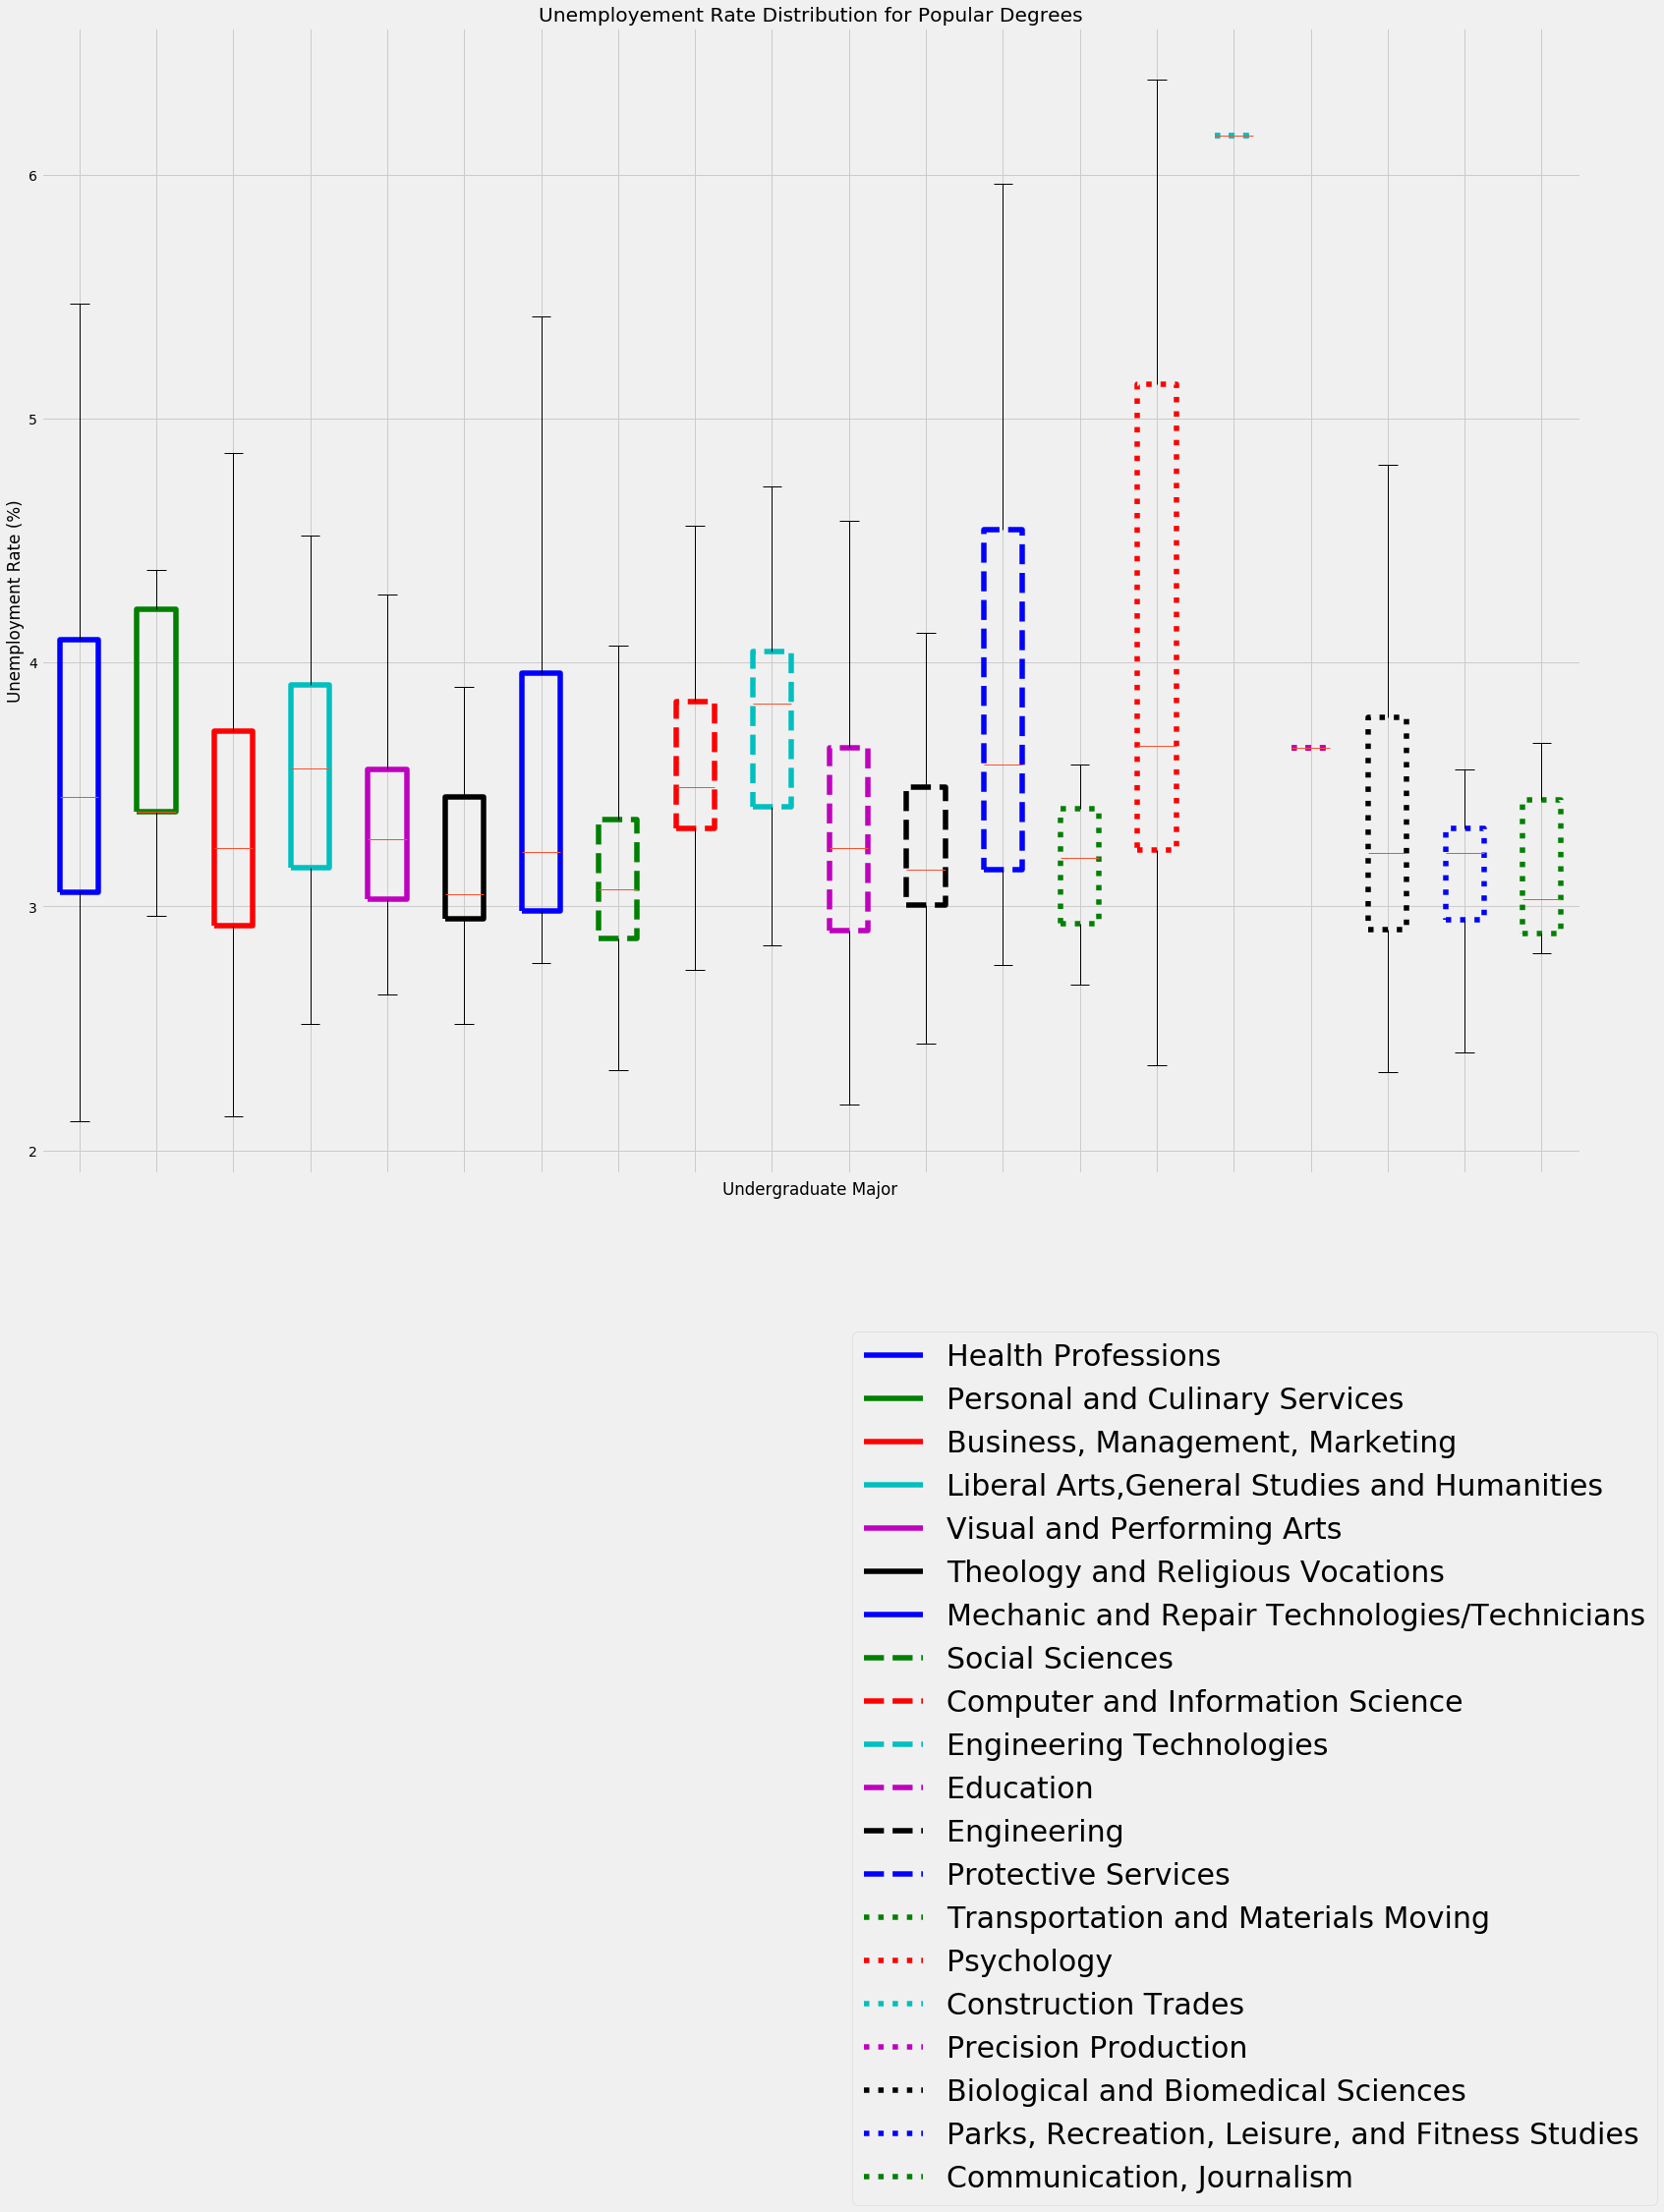

In [18]:
# begin plotting
f, ax = plt.subplots(figsize=(25,20))

# list of lists containing each popular degree's list of unemployement rates
unemp_dist = list(major_unemp_dict.values())
# ensure all values are floats
unemp_dist = make_floats(unemp_dist)
# get actual degree values
unemp_dist_keys = list(major_unemp_dict.keys())
# create box plot for each degrees list of unemployement rates
boxplot_dict = ax.boxplot(unemp_dist, sym='', labels=unemp_dist_keys)

# iterater for colors
cycol = cycle('bgrcmk')
# normal iterator
i=0
for b in boxplot_dict['boxes']:
    # set labels
    lab = unemp_dist_keys[i]
    b.set_label(lab)
    # set color
    col = next(cycol)
    b.set_color(col)
    # set linewidth
    b.set_linewidth(5.5)
    # change type of line 
    if(i <= 6):
        b.set_linestyle('-')
    elif(i > 6 and i <=12):
        b.set_linestyle('--')
    else:
        b.set_linestyle(':')
    i+=1
    
ax.set_xticks(range(1,21))
ax.set_xticklabels([]*20, rotation=90, fontsize=16)
ax.set_xlabel('Undergraduate Major')
ax.set_ylabel('Unemployment Rate (%)')
ax.set_title('Unemployement Rate Distribution for Popular Degrees')
plt.legend(bbox_to_anchor=(1.05, -.90), loc=4, borderaxespad=0., prop={'size': 30})
plt.show()

# Multivariate Linear Regression

In [177]:
# set up df for analysis
df_edu_reg = df_edu[df_edu.columns.values[1:]]
# remove private data points
df_edu_reg = df_edu_reg.replace('PrivacySuppressed', np.nan)
# remove nan
df_edu_reg = df_edu_reg.dropna()

In [178]:
# length of dataset + 1 for iterating purposes later
df_edu_reg_len = len(df_edu_reg)+1
# length of column
df_edu_reg_col_len = len(df_edu_reg.columns)

In [179]:
# function to compute standard error and square error
def compute_error(X_test, y_test):
    sum = 0
    sq_err = 0
    for i in range(len(y_test)):
        pred = clf.predict([X_test[i]])
        error = abs((y_test[i] - pred[0]))/y_test[i] if y_test[i] != 0 else 0

        sum += error**2
        
    return (((sum)/(len(y_test)))**.5 * 100)

In [180]:
# columns 
df_edu_reg.columns

Index(['PCIP01', 'PCIP03', 'PCIP04', 'PCIP05', 'PCIP09', 'PCIP10', 'PCIP11',
       'PCIP12', 'PCIP13', 'PCIP14', 'PCIP15', 'PCIP16', 'PCIP19', 'PCIP22',
       'PCIP23', 'PCIP24', 'PCIP25', 'PCIP26', 'PCIP27', 'PCIP29', 'PCIP30',
       'PCIP31', 'PCIP38', 'PCIP39', 'PCIP40', 'PCIP41', 'PCIP42', 'PCIP43',
       'PCIP44', 'PCIP45', 'PCIP46', 'PCIP47', 'PCIP48', 'PCIP49', 'PCIP50',
       'PCIP51', 'PCIP52', 'PCIP54', 'MN_EARN_WNE_P10', 'MD_EARN_WNE_P10',
       'ADM_RATE'],
      dtype='object')

In [181]:
# create feature set (independent variables), see columns above for reference
# features include: degree percentages and mean earnings after 10 years 
X = [df_edu_reg.iloc[i-1:i, 1:df_edu_reg_col_len-2].values[0] for i in range(1, df_edu_reg_len)]

# ensure all values are floats
X = make_floats(X)

# create label - admission rate (dependent variable)
# admission rate is the value we are trying to predict
y = [row['ADM_RATE'] for _,row in df_edu_reg.iterrows()]

# separate data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [182]:
# init regressor
clf = LinearRegression()
# fit regressor
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [183]:
# score
clf.score(X_train, y_train)

0.27329030127065801

In [184]:
# compute error
# need to fix
std_err = compute_error(X_test, y_test)
print('Std error: ' + str(std_err))

Std error: 49.4341963914


In [185]:
df_edu_reg.columns

Index(['PCIP01', 'PCIP03', 'PCIP04', 'PCIP05', 'PCIP09', 'PCIP10', 'PCIP11',
       'PCIP12', 'PCIP13', 'PCIP14', 'PCIP15', 'PCIP16', 'PCIP19', 'PCIP22',
       'PCIP23', 'PCIP24', 'PCIP25', 'PCIP26', 'PCIP27', 'PCIP29', 'PCIP30',
       'PCIP31', 'PCIP38', 'PCIP39', 'PCIP40', 'PCIP41', 'PCIP42', 'PCIP43',
       'PCIP44', 'PCIP45', 'PCIP46', 'PCIP47', 'PCIP48', 'PCIP49', 'PCIP50',
       'PCIP51', 'PCIP52', 'PCIP54', 'MN_EARN_WNE_P10', 'MD_EARN_WNE_P10',
       'ADM_RATE'],
      dtype='object')

In [186]:
# new regression model to predict 10 year median earnings
features = []
# dependent variables
for i in range(1, df_edu_reg_len):
    # use degree percentages as features
    majors = df_edu_reg.iloc[i-1:i, 1:df_edu_reg_col_len-3].values[0]
    # use admission rate as feature
    earnings_adm_rate = df_edu_reg.iloc[i-1:i, -1:].values[0]
    majors = np.append(majors,earnings_adm_rate)
    features.append(majors)

In [187]:
# create label - 10 year median earnings (independent variable)
y = [df_edu_reg.iloc[i-1:i, df_edu_reg_col_len - 2:df_edu_reg_col_len - 1].values[0] for i in range(1,df_edu_reg_len)]
# ensure all values are floats
y = make_floats(y)
# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(features,y, test_size=0.2)

In [188]:
# init regressor
clf = LinearRegression()
# fit regressor
clf.fit(X_train,y_train)
clf.predict([X_test[0]])

array([[ 33928.38044819]])

In [189]:
# compute error
std_err = compute_error(X_test, y_test)
print('Std error: ' + str(std_err))

Std error: [27.266840345290767]


In [190]:
# R^2 value
clf.score(X_test,y_test)

0.50739664046663502

In [201]:
# pruning health profession percentages higher than 50%
df_edu_reg  = df_edu_reg[df_edu_reg['PCIP51'] < .5]
df_edu_reg_len = len(df_edu_reg)

In [202]:
df_edu_reg.columns

Index(['PCIP01', 'PCIP03', 'PCIP04', 'PCIP05', 'PCIP09', 'PCIP10', 'PCIP11',
       'PCIP12', 'PCIP13', 'PCIP14', 'PCIP15', 'PCIP16', 'PCIP19', 'PCIP22',
       'PCIP23', 'PCIP24', 'PCIP25', 'PCIP26', 'PCIP27', 'PCIP29', 'PCIP30',
       'PCIP31', 'PCIP38', 'PCIP39', 'PCIP40', 'PCIP41', 'PCIP42', 'PCIP43',
       'PCIP44', 'PCIP45', 'PCIP46', 'PCIP47', 'PCIP48', 'PCIP49', 'PCIP50',
       'PCIP51', 'PCIP52', 'PCIP54', 'MN_EARN_WNE_P10', 'MD_EARN_WNE_P10',
       'ADM_RATE'],
      dtype='object')

In [203]:
# new regression model to predict 10 year median earnings
features = []
# dependent variables
for i in range(1, df_edu_reg_len):
    # use degree percentages as features
    majors = df_edu_reg.iloc[i-1:i, 1:df_edu_reg_col_len-3].values[0]
    # use admission rate as feature
    earnings_adm_rate = df_edu_reg.iloc[i-1:i, -1:].values[0]
    majors = np.append(majors,earnings_adm_rate)
    features.append(majors)

In [204]:
# create label - 10 year median earnings (independent variable)
y = [df_edu_reg.iloc[i-1:i, df_edu_reg_col_len - 2:df_edu_reg_col_len - 1].values[0] for i in range(1,df_edu_reg_len)]
# ensure all values are floats
y = make_floats(y)
# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(features,y, test_size=0.2)

In [205]:
# init regressor
clf = LinearRegression()
# fit regressor
clf.fit(X_train,y_train)
clf.predict([X_test[0]])

array([[ 80160.27668642]])

In [206]:
# compute error
std_err = compute_error(X_test, y_test)
print('Std error: ' + str(std_err))

Std error: [23.153914790377918]


In [207]:
# R^2 value
clf.score(X_test,y_test)

0.52485195934564066